<a href="https://colab.research.google.com/github/chefdarek/DS-Unit-2-Classification-1/blob/master/module4-confusion-matrix/EnsembleMethods_and_Stack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
!pip install category_encoders
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import make_pipeline

pd.set_option('display.float_format', '{:.2f}'.format)

train_features = pd.read_csv('https://drive.google.com/uc?export=download&id=14ULvX0uOgftTB2s97uS8lIx1nHGQIB0P')
train_labels = pd.read_csv('https://drive.google.com/uc?export=download&id=1r441wLr7gKGHGLyPpKauvCuUOU556S2f')
test_features = pd.read_csv('https://drive.google.com/uc?export=download&id=1wvsYl9hbRbZuIuoaLWCsW_kbcxCdocHz')
sample_submission = pd.read_csv('https://drive.google.com/uc?export=download&id=1kfJewnmhowpUo381oSn3XqsQ6Eto23XV')

print('train_features', train_features.shape)
print('train_labels', train_labels.shape)
print('test_features', test_features.shape)
print('sample_submission', sample_submission.shape)

train_features (59400, 40)
train_labels (59400, 2)
test_features (14358, 40)
sample_submission (14358, 2)


In [4]:
train_features.select_dtypes('object')

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,2011-03-14,Roman,Roman,none,Lake Nyasa,Mnyusi B,Iringa,Ludewa,Mundindi,True,GeoData Consultants Ltd,VWC,Roman,False,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,2013-03-06,Grumeti,GRUMETI,Zahanati,Lake Victoria,Nyamara,Mara,Serengeti,Natta,NaN,GeoData Consultants Ltd,Other,NaN,True,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,2013-02-25,Lottery Club,World vision,Kwa Mahundi,Pangani,Majengo,Manyara,Simanjiro,Ngorika,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,2013-01-28,Unicef,UNICEF,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,Mahakamani,Mtwara,Nanyumbu,Nanyumbu,True,GeoData Consultants Ltd,VWC,NaN,True,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,2011-07-13,Action In A,Artisan,Shuleni,Lake Victoria,Kyanyamisa,Kagera,Karagwe,Nyakasimbi,True,GeoData Consultants Ltd,NaN,NaN,True,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
5,2011-03-13,Mkinga Distric Coun,DWE,Tajiri,Pangani,Moa/Mwereme,Tanga,Mkinga,Moa,True,GeoData Consultants Ltd,VWC,Zingibali,True,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,salty,salty,enough,enough,other,other,unknown,communal standpipe multiple,communal standpipe
6,2012-10-01,Dwsp,DWSP,Kwa Ngomho,Internal,Ishinabulandi,Shinyanga,Shinyanga Rural,Samuye,True,GeoData Consultants Ltd,VWC,NaN,True,swn 80,swn 80,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
7,2012-10-09,Rwssp,DWE,Tushirikiane,Lake Tanganyika,Nyawishi Center,Shinyanga,Kahama,Chambo,True,GeoData Consultants Ltd,NaN,NaN,True,nira/tanira,nira/tanira,handpump,wug,user-group,unknown,unknown,milky,milky,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
8,2012-11-03,Wateraid,Water Aid,Kwa Ramadhan Musa,Lake Tanganyika,Imalauduki,Tabora,Tabora Urban,Itetemia,True,GeoData Consultants Ltd,VWC,NaN,True,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,salty,salty,seasonal,seasonal,machine dbh,borehole,groundwater,hand pump,hand pump
9,2011-08-03,Isingiro Ho,Artisan,Kwapeto,Lake Victoria,Mkonomre,Kagera,Karagwe,Kaisho,True,GeoData Consultants Ltd,NaN,NaN,True,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump


In [ ]:
X = pd.DataFrame(train_features.select_dtypes('number'))
#X = X.drop('date_recorded', axis=1)
y = train_labels.status_group

In [22]:
X.head()
y.head()

0        functional
1        functional
2        functional
3    non functional
4        functional
Name: status_group, dtype: object

/usr/local/lib/python3.6/dist-packages/yellowbrick/features/rankd.py:262: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X = X.as_matrix()


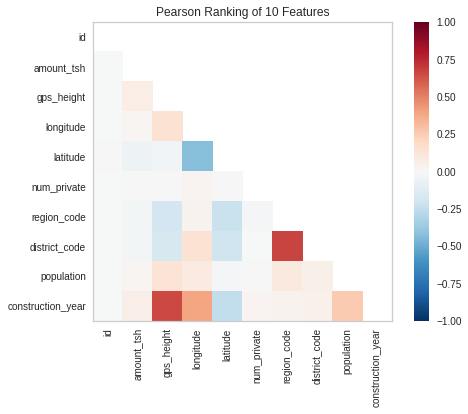

In [20]:
from yellowbrick.features import Rank2D

visualizer = Rank2D(algorithm="pearson")
visualizer.fit_transform(X,y)
visualizer.poof()

In [ ]:
def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()

    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']    
    
    # Drop recorded_by (never varies) and id (always varies, random)
    X = X.drop(columns=['recorded_by', 'id'])
    
    # Drop duplicate columns
    duplicate_columns = ['quantity_group']
    X = X.drop(columns=duplicate_columns)
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these like null values
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    
    #GPS height
    X['gps_height'] = X['gps_height'].replace(0, X['gps_height'].mean() )
    
    # When columns have zeros and shouldn't, they are like null values
    cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        
    # For categoricals with missing values, fill with the category 'MISSING'
    #categoricals = X.select_dtypes(exclude='number').columns
    #for col in categoricals:
        #X[col] = X[col].fillna('MISSING')
    
    return X


In [ ]:
train_features = wrangle(train_features)
test_features = wrangle(test_features)

In [ ]:
#train_features.isna().sum()

In [ ]:
drop = ["funder",
        "ward",
]
train_features.drop(drop, axis=1, inplace=True)
test_features.drop(drop, axis=1, inplace=True)

In [ ]:
train_features.dtypes

In [ ]:
catsd = [
    'installer', 'wpt_name','basin',
     'subvillage','region','lga','public_meeting',
     'scheme_management','scheme_name','extraction_type',
     'extraction_type_group','extraction_type_class','management',
     'management_group','payment','payment_type',
     'water_quality','quality_group','quantity','source',
     'source_type','source_class','waterpoint_type','waterpoint_type_group'
]

In [ ]:
for x in catsd:
  
  train_features[x] = train_features[x].astype('category')
  test_features[x] = test_features[x].astype('category')


In [ ]:
cat_columns = train_features.select_dtypes(['category']).columns
  
train_features[cat_columns] = train_features[cat_columns].apply(lambda x: x.cat.codes)
test_features[cat_columns] = test_features[cat_columns].apply(lambda x: x.cat.codes)
for x in cat_columns:
  train_features[x] = train_features[x].astype('float64')
  test_features[x] = test_features[x].astype('float64')
train_features[cat_columns] = train_features[cat_columns].apply(lambda x: x.round())
test_features[cat_columns] = test_features[cat_columns].apply(lambda x: x.round())

In [ ]:
 train_features['longitude'].describe()

In [ ]:
 train_features['longitude'] =  pd.qcut( train_features['longitude'],5, labels=None, retbins=False, precision=3)

In [ ]:
train_features['latitude'].describe()

In [ ]:
train_features['latitude'] = pd.qcut( train_features['latitude'],5, labels=None, retbins=False, precision=3)

In [ ]:
train_features['construction_year'] = pd.qcut( train_features['construction_year'],5, labels=None, retbins=False)

In [ ]:
latlong = ['latitude', 'longitude', 'construction_year']
for x in latlong:
  train_features[x] = train_features[x].astype('category')
  test_features[x] = test_features[x].astype('category')
  test_features[x]

In [ ]:
train_features[latlong] = train_features[latlong].apply(lambda x: x.cat.codes)

In [ ]:
for x in latlong:
  train_features[x] = train_features[x].astype('float64')
  test_features[x] = test_features[x].astype('float64')

In [ ]:
train_features.dtypes

In [ ]:
train_features.head()

In [ ]:
X_train = train_features
y_train = train_labels['status_group']

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, train_size=0.80, test_size=0.20, 
    stratify=y_train, random_state=42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

In [ ]:
categorical_features = [
    'quantity','extraction_type',
    'extraction_type_group','management',
    'management_group','source','source_type',
    'waterpoint_type','basin','region',
    'scheme_management','extraction_type_class',
    'payment','payment_type','waterpoint_type_group',
    'latitude','longitude',
    
    
]

numeric_features = X_train.select_dtypes('number').columns.tolist()
features = categorical_features + numeric_features

X_train_subset = X_train[features]
X_val_subset = X_val[features]
X_test = test_features[features]

In [ ]:
X_train_subset.isna().sum()

In [ ]:


# Make pipeline!
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    RobustScaler(),
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=800, n_jobs=-1)
    
)

# Fit on train, score on val, predict on test
pipeline.fit(X_train_subset, y_train)
print('Validation Accuracy', pipeline.score(X_val_subset, y_val))
y_pred = pipeline.predict(X_test)

# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-Rob_Simple.csv', index=False)

In [ ]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    QuantileTransformer(),
    IterativeImputer(), 
    RandomForestClassifier(n_estimators=800, n_jobs=-1)
    
)

# Fit on train, score on val, predict on test
pipeline.fit(X_train_subset, y_train)
print('Validation Accuracy', pipeline.score(X_val_subset, y_val))
y_pred = pipeline.predict(X_test)

# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-Q_Iterative.csv', index=False)

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier


In [ ]:
HGBC = HistGradientBoostingClassifier()
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    QuantileTransformer(),
    IterativeImputer(), 
    HistGradientBoostingClassifier(max_depth=50)
    
)

# Fit on train, score on val, predict on test
pipeline.fit(X_train_subset, y_train)
print('Validation Accuracy', pipeline.score(X_val_subset, y_val))
y_pred = pipeline.predict(X_test)

# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-HGBC_Iterative.csv', index=False)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    QuantileTransformer(),
    IterativeImputer(), 
    ExtraTreesClassifier(n_estimators=800, n_jobs=-1)
    
)

# Fit on train, score on val, predict on test
pipeline.fit(X_train_subset, y_train)
print('Validation Accuracy', pipeline.score(X_val_subset, y_val))
y_pred = pipeline.predict(X_test)

# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-Tree_Iterative.csv', index=False)

In [ ]:


# Filenames of your submissions you want to ensemble
files = ['submission-Rob_Simple.csv', 'submission-HGBC_Iterative.csv', 'submission-Q_Iterative.csv', 'submission-Tree_Iterative.csv']

submissions = (pd.read_csv(file)[['status_group']] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

submission = sample_submission.copy()
submission['status_group'] = majority_vote
submission.to_csv('my-ultimate-ensemble-binsHistbinsx.csv', index=False)